<a href="https://colab.research.google.com/github/globalpie271/assistments2015-knowledge-tracing/blob/main/assistments2015_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# !pip install --upgrade matplotlib
# !pip uninstall matplotlib

In [ ]:
import os
import sys
import glob
# import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gensim
# import numba
# import pickle
# import seaborn as sns
# import time

In [ ]:
PATH = os.path.join('gdrive', 'MyDrive', r'Colab Notebooks', 'FQW')
SRC_PATH = os.path.join(PATH, 'src')
DATA_PATH = os.path.join(PATH, 'data')
MODELS_PATH = os.path.join(DATA_PATH, 'models')
HISTORY_PATH = os.path.join(DATA_PATH, 'history')
ASSISTMENT_PATH = os.path.join(DATA_PATH, 'ASSISTment')



ASSISTMENT_2015_PATH = os.path.abspath('2015_100_skill_builders_main_problems.csv')

# Feature functions, loss and metrics

In [ ]:
def get_word2vec(fn, skill_with_answer = True, embedding_size = 10, round = True):
# TODO: add average of embeddings for each exercise
    df = pd.read_csv(fn)
    if round:
      df['correct'] = df['correct'].round()
    else:
      df = df[df.correct.isin([1.,0.])]

    
    # embedding_size = 10
    
    df.dropna(subset=['sequence_id'], inplace=True)

    df = df.groupby('user_id').filter(lambda q: len(q) > 1).copy()

    df['skill'], _ = pd.factorize(df['sequence_id'], sort=True)

    if skill_with_answer:
      df['skill_with_answer'] = df['skill'] * 2 + df['correct']
      df['skill_str'] = df['skill_with_answer'].apply(str)
    else:
      df['skill_str'] = df['skill'].apply(str)  #TODO: skill_with_answer instead of skill

    word2vec = gensim.models.Word2Vec(pd.Series(df['skill_str'].unique()).apply(lambda q:[q]), size=embedding_size, min_count=1)
    # dct = dict(zip(word2vec.wv.index2word, word2vec.wv.vectors))   
    return word2vec, df, skill_with_answer

In [ ]:
def get_embedding_features(df, word2vec, shuffle = True, random_seed = 5, skill_with_answer = True):
    seq = df.groupby('user_id').apply(
        lambda r: (
            word2vec.wv[r['skill_str'].values[:-1]],
            r['skill'].values[1:],
            r['correct'].values[1:],
        )
    )
    nb_users = len(seq)

    dataset = tf.data.Dataset.from_generator(
        generator=lambda: seq,
        output_types=(tf.float32,
                      tf.int32, tf.float32)
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=nb_users, seed = random_seed)

    features_depth = word2vec.wv.vector_size
    skill_depth = df['skill'].max() + 1

    dataset = dataset.map(
        lambda feat, skill, label: (
            feat,
            tf.concat(
                values=[
                    tf.one_hot(skill, depth=skill_depth),
                    tf.expand_dims(label, -1)
                ],
                axis=-1
            )
        )
    )
    return dataset, features_depth, skill_depth, nb_users

In [ ]:
# import tfds.features.Featimport tensorflow_datasets.features.FeaturesDict as FeaturesDict
# uresDict as FeaturesDict

def get_eern_features(df, word2vec, shuffle = True, random_seed = 5, skill_with_answer = False):
    def add_zeros(arrays, answers):
      assert arrays.shape[1]%2==0
      result = np.zeros([arrays.shape[0], 2 * arrays.shape[1]])

      for i, answer in enumerate(answers):
        if answer>0.5:
          result[i,0:arrays.shape[1]] = np.array(arrays[i])
        else:
          result[i,arrays.shape[1]:2*result.shape[1]] = np.array(arrays[i])
      return result



    seq = df.groupby('user_id').apply(
        lambda r: (
            add_zeros(word2vec.wv[r['skill_str'].values[:-1]], r['correct'].values[:-1]),
            # r['correct'].values[:-1],
            r['skill'].values[1:],
            r['correct'].values[1:],
        )
    )
    nb_users = len(seq)

    dataset = tf.data.Dataset.from_generator(
        generator=lambda: seq,
        output_types=(tf.float32, tf.int32, tf.float32)
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=nb_users, seed = random_seed)

    features_depth = word2vec.wv.vector_size
    skill_depth = df['skill'].max() + 1

    dataset = dataset.map(
        lambda feat, skill, label: (
            feat,
            tf.concat(
                values=[
                    tf.one_hot(skill, depth=skill_depth),
                    tf.expand_dims(label, -1)
                ],
                axis=-1
            )
        )
    )
    features_depth *= 2 

    return dataset, features_depth, skill_depth, nb_users

In [ ]:
def get_default_features(fn, shuffle = True, correct_rounded = True, random_seed = 5, round = True):
    df = pd.read_csv(fn)
    if round:
      df['correct'] = df['correct'].round()
    else:
      df = df[df.correct.isin([1.,0.])]
    
    df = df.groupby('user_id').filter(lambda interaction: len(interaction) > 1).copy()

    df['skill'], _ = pd.factorize(df['sequence_id'], sort=True)
    if correct_rounded:
        df['correct_modified'] = df['correct'].round()
    else:
        df['correct_modified'] = df['correct']

    seq = df.groupby('user_id').apply(
        lambda r: (
            r['skill'].values[:-1],
            r['correct_modified'].values[:-1],
            r['skill'].values[1:],
            r['correct_modified'].values[1:],
        )
    )
    users_number = len(seq)

    dataset = tf.data.Dataset.from_generator(
        generator=lambda: seq,
        output_types=(tf.int32, tf.int32, tf.int32, tf.float32)
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=users_number, seed = random_seed)

    features_depth = df['skill'].unique().shape[0] + 2
    skill_depth = df['skill'].unique().shape[0]
    correct_depth = df['correct_modified'].unique().shape[0]

    dataset = dataset.map(
        lambda feat_skill, feat_correct, skill, label: (
            tf.concat(
                values=[
                    tf.one_hot(feat_skill, depth=features_depth - 2),
                    tf.one_hot(feat_correct, depth = correct_depth)
                ],
                axis=-1
            ),
            tf.concat(
                values=[
                    tf.one_hot(skill, depth=skill_depth),
                    tf.expand_dims(label, -1)
                ],
                axis=-1
            )
        )
    )
    
    return dataset, features_depth, skill_depth, users_number

In [ ]:
def get_cross_features(fn, shuffle = True, random_seed = 5, round = True):
    df = pd.read_csv(fn)
    if round:
      df['correct'] = df['correct'].round()
    else:
      df = df[df.correct.isin([1.,0.])]

    df.dropna(subset=['sequence_id'], inplace=True)

    df = df.groupby('user_id').filter(lambda q: len(q) > 1).copy()

    df['skill'], _ = pd.factorize(df['sequence_id'], sort=True)

    df['skill_with_answer'] = df['skill'] * 2 + df['correct']

    seq = df.groupby('user_id').apply(
        lambda r: (
            r['skill_with_answer'].values[:-1],
            r['skill'].values[1:],
            r['correct'].values[1:],
        )
    )
    nb_users = len(seq)

    dataset = tf.data.Dataset.from_generator(
        generator=lambda: seq,
        output_types=(tf.int32, tf.int32, tf.float32)
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=nb_users, seed = random_seed)

    features_depth = int(df['skill_with_answer'].max()) + 1
    skill_depth = df['skill'].max() + 1

    dataset = dataset.map(
        lambda feat, skill, label: (
            tf.one_hot(feat, depth=features_depth),
            tf.concat(
                values=[
                    tf.one_hot(skill, depth=skill_depth),
                    tf.expand_dims(label, -1)
                ],
                axis=-1
            )
        )
    )
    return dataset, features_depth, skill_depth, nb_users

In [ ]:
def get_dataset(path, batch_size = 32, shuffle = True, features_func = get_default_features, MASK_VALUE = -1.0):
    dataset, features_depth, skill_depth, users_number = features_func(path, shuffle)
    
    dataset = dataset.padded_batch(
        batch_size=batch_size,
        padding_values=(MASK_VALUE, MASK_VALUE),
        padded_shapes=([None, None], [None, None]),
        drop_remainder=True
    )

    length = users_number // batch_size
    return dataset, length, features_depth, skill_depth
    # return dataset, length
    


In [ ]:
def get_embedding_dataset(dataset, features_depth, skill_depth, users_number, batch_size = 32, shuffle = True, MASK_VALUE = -1.0):
    
    dataset = dataset.padded_batch(
        batch_size=batch_size,
        padding_values=(MASK_VALUE, MASK_VALUE),
        padded_shapes=([None, None], [None, None]),
        drop_remainder=True
    )

    length = users_number // batch_size
    return dataset, length


In [ ]:
def get_target(y_true, y_pred):
    mask = 1. - tf.cast(tf.equal(y_true, MASK_VALUE), y_true.dtype)
    y_true = y_true * mask

    skills, y_true = tf.split(y_true, num_or_size_splits=[-1, 1], axis=-1)

    y_pred = tf.reduce_sum(y_pred * skills, axis=-1, keepdims=True)

    return y_true, y_pred

In [ ]:
def split_dataset(dataset, total_size, test_fraction, val_fraction=None):
    def split(dataset, split_size):
        split_set = dataset.take(split_size)
        dataset = dataset.skip(split_size)
        return dataset, split_set

    if not 0 < test_fraction < 1:
        raise ValueError("test_fraction must be between (0, 1)")

    if val_fraction is not None and not 0 < val_fraction < 1:
        raise ValueError("val_fraction must be between (0, 1)")

    test_size = np.ceil(test_fraction * total_size)
    train_size = total_size - test_size

    if test_size == 0 or train_size == 0:
        raise ValueError(
            "The train and test datasets must have at least 1 element. Reduce the split fraction or get more data.")

    train_set, test_set = split(dataset, test_size)

    val_set = None
    if val_fraction:
        val_size = np.ceil(train_size * val_fraction)
        train_set, val_set = split(train_set, val_size)

    return train_set, test_set, val_set


In [ ]:
import tensorflow as tf

MASK_VALUE = -1.0

class BinaryAccuracy(tf.keras.metrics.BinaryAccuracy):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(BinaryAccuracy, self).update_state(y_true=true,
                                                 y_pred=pred,
                                                 sample_weight=sample_weight)


class AUC(tf.keras.metrics.AUC):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(AUC, self).update_state(y_true=true,
                                                 y_pred=pred,
                                                 sample_weight=sample_weight)


class Precision(tf.keras.metrics.Precision):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(Precision, self).update_state(y_true=true,
                                            y_pred=pred,
                                            sample_weight=sample_weight)


class Recall(tf.keras.metrics.Recall):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(Recall, self).update_state(y_true=true,
                                         y_pred=pred,
                                         sample_weight=sample_weight)


class SensitivityAtSpecificity(tf.keras.metrics.SensitivityAtSpecificity):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(SensitivityAtSpecificity, self).update_state(y_true=true,
                                                           y_pred=pred,
                                                           sample_weight=sample_weight)


class SpecificityAtSensitivity(tf.keras.metrics.SpecificityAtSensitivity):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(SpecificityAtSensitivity, self).update_state(y_true=true,
                                                           y_pred=pred,
                                                           sample_weight=sample_weight)


class FalseNegatives(tf.keras.metrics.FalseNegatives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(FalseNegatives, self).update_state(y_true=true,
                                                 y_pred=pred,
                                                 sample_weight=sample_weight)


class FalsePositives(tf.keras.metrics.FalsePositives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(FalsePositives, self).update_state(y_true=true,
                                                 y_pred=pred,
                                                 sample_weight=sample_weight)


class TrueNegatives(tf.keras.metrics.TrueNegatives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(TrueNegatives, self).update_state(y_true=true,
                                                y_pred=pred,
                                                sample_weight=sample_weight)


class TruePositives(tf.keras.metrics.TruePositives):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(TrueNegatives, self).update_state(y_true=true,
                                                y_pred=pred,
                                                sample_weight=sample_weight)

In [ ]:
def custom_loss(y_true, y_pred):
    y_true, y_pred = get_target(y_true, y_pred)
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)

# MultiHeadAttention and LSTM

In [ ]:
mh_dataset, mh_length, mh_features_depth, mh_skill_depth = get_dataset(ASSISTMENT_2015_PATH, batch_size = 128,
                                                           features_func=get_cross_features)

In [ ]:
mh_length, mh_features_depth, mh_skill_depth

(151, 200, 100)

In [ ]:
mh_train_set, mh_test_set, mh_val_set = split_dataset(mh_dataset, mh_length, 0.2, 0.2)

In [ ]:
sum = 0
for batch in mh_test_set:
  sum += batch[0].shape[0]

KeyboardInterrupt: ignored

In [ ]:
sum

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Masking, LSTM, TimeDistributed, Dense, MultiHeadAttention, Input
# from keras_self_attention import SeqSelfAttention

key_dim = 10

# model = tf.keras.models.Sequential(name = 'MH-LSTM')

input = Input(shape=(None, mh_features_depth), name = 'input')
mask = Masking(mask_value = -1., input_shape = (None, mh_features_depth), name = 'masking')(input)
lstm_output = LSTM(mh_features_depth, return_sequences = True, name = 'lstm')(mask)
attention = MultiHeadAttention(num_heads=1,key_dim=mh_features_depth, name = 'attention')(lstm_output, mask)
# attention = 
# output = TimeDistributed(Dense(sakt_skill_depth, activation = 'sigmoid', name = 'dense'), name = 'timedistributed')(attention)
output = Dense(mh_skill_depth, activation = 'sigmoid', name = 'dense')(attention)

mh_model = Model(inputs = input, outputs = output , name = 'MH-LSTM')

mh_model.compile(
        loss = custom_loss,
        optimizer='adam',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
        ])

mh_model.summary()

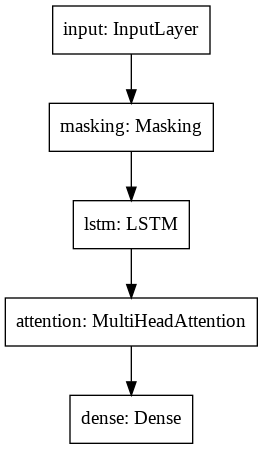

In [ ]:
tf.keras.utils.plot_model(mh_model)

In [ ]:
import tensorflow as tf

model_name = mh_model.name
best_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_best.hdf5'),
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
last_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_last.hdf5'),
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
 
callbacks = [best_w, last_w]



mh_history = mh_model.fit(mh_train_set,
                    epochs = 50,
                    verbose = 1,
                    validation_data=mh_val_set,
                    callbacks = callbacks)

Epoch 1/50
96/96 [==============================] - 27s 216ms/step - loss: 0.0897 - binary_accuracy: 0.9611 - auc_4: 0.9821 - precision_4: 0.7351 - recall_4: 0.9828 - val_loss: 0.0763 - val_binary_accuracy: 0.9651 - val_auc_4: 0.9864 - val_precision_4: 0.7284 - val_recall_4: 1.0000

Epoch 00001: val_loss improved from inf to 0.07626, saving model to gdrive/MyDrive/Colab Notebooks/FQW/data/models/MH-LSTM_best.hdf5
Epoch 2/50
96/96 [==============================] - 13s 105ms/step - loss: 0.0840 - binary_accuracy: 0.9617 - auc_4: 0.9853 - precision_4: 0.7335 - recall_4: 0.9974 - val_loss: 0.0778 - val_binary_accuracy: 0.9652 - val_auc_4: 0.9873 - val_precision_4: 0.7329 - val_recall_4: 0.9987

Epoch 00002: val_loss did not improve from 0.07626
Epoch 3/50
96/96 [==============================] - 13s 107ms/step - loss: 0.0824 - binary_accuracy: 0.9619 - auc_4: 0.9863 - precision_4: 0.7364 - recall_4: 0.9917 - val_loss: 0.0829 - val_binary_accuracy: 0.9618 - val_auc_4: 0.9867 - val_precisio

In [ ]:
filename = os.path.join(HISTORY_PATH, 'LSTM-Multihead1.csv')

history_df = pd.DataFrame(mh_history.history)
history_df.to_csv(filename)

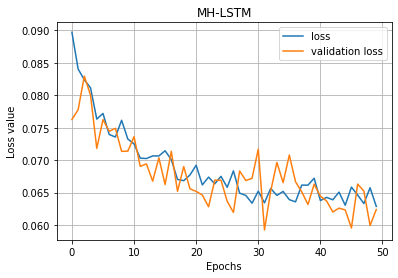

In [ ]:
import matplotlib.pyplot as plt

mh_loss = mh_history.history['loss']
mh_val_loss = mh_history.history['val_loss']
epochs = np.arange(len(mh_loss))
plt.plot(epochs, mh_loss, label = 'loss')
plt.plot(epochs, mh_val_loss, label = 'validation loss')
plt.title('MH-LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import h5py

file = h5py.File(os.path.join(MODELS_PATH, model_name +'_best.hdf5'),'r')
best_mh_model = tf.keras.models.load_model(file, compile=False)

best_mh_model.compile(
        loss = custom_loss,
        optimizer='adam',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
        ])



mh_result = mh_model.evaluate(mh_test_set, verbose=1)
best_mh_result = best_mh_model.evaluate(mh_test_set, verbose=1)
# 31/31 [==============================] - 4s 46ms/step - loss: 0.0628 - binary_accuracy: 0.9717 - auc_5: 0.9934 - precision_5: 0.8309 - recall_5: 0.9230
# 31/31 [==============================] - 5s 50ms/step - loss: 0.0623 - binary_accuracy: 0.9718 - auc_7: 0.9932 - precision_7: 0.8017 - recall_7: 0.9385


# best_mh_result = best_mh_model.evaluate(mh_test_set, verbose=1)
# 200 dim cross features
# 31/31 [==============================] - 4s 46ms/step - loss: 0.0628 - binary_accuracy: 0.9717 - auc_5: 0.9934 - precision_5: 0.8309 - recall_5: 0.9230
# 31/31 [==============================] - 5s 50ms/step - loss: 0.0623 - binary_accuracy: 0.9718 - auc_7: 0.9932 - precision_7: 0.8017 - recall_7: 0.9385
# 100 dim emb features
# 31/31 [==============================] - 3s 28ms/step - loss: 0.0764 - binary_accuracy: 0.9649 - auc: 0.9888 - precision: 0.7569 - recall: 0.9595

# 100 dim emb features 2 mh layers
# 31/31 [==============================] - 4s 41ms/step - loss: 0.0713 - binary_accuracy: 0.9673 - auc_4: 0.9905 - precision_4: 0.7872 - recall_4: 0.9203

31/31 [==============================] - 5s 50ms/step - loss: 0.0623 - binary_accuracy: 0.9718 - auc_7: 0.9932 - precision_7: 0.8017 - recall_7: 0.9385


In [ ]:
# mh_model.evaluate(mh_dataset, verbose=1)

151/151 [==============================] - 9s 46ms/step - loss: 0.0622 - binary_accuracy: 0.9727 - auc_4: 0.9937 - precision_4: 0.8271 - recall_4: 0.9237


[0.06216760352253914,
 0.972701907157898,
 0.9936519265174866,
 0.8271026611328125,
 0.9237157106399536]

# Luong Attention (or MultiHeadAttention), NAKTM ideas and LSTM

In [ ]:
from collections import OrderedDict

word2vec, df, skill_with_answer = get_word2vec(ASSISTMENT_2015_PATH, embedding_size = 50) # TODO: Try features from EERN

exercise2vec, _, _ = get_word2vec(ASSISTMENT_2015_PATH, skill_with_answer=False, embedding_size=50)
dct = dict(zip(exercise2vec.wv.index2word, exercise2vec.wv.vectors))
dct = {int(key.split('.')[0]):value for key, value in dct.items()}
exercise_embeddings = tf.constant([value for key, value in sorted(dct.items())])
exercise_embeddings = tf.transpose(exercise_embeddings)

In [ ]:
add_dataset, add_features_depth, add_skill_depth, add_users = get_embedding_features(df, word2vec)
add_dataset, add_length = get_embedding_dataset(add_dataset, add_features_depth, add_skill_depth, add_users, batch_size = 128)

In [ ]:
exercise_embeddings

<tf.Tensor: shape=(50, 100), dtype=float32, numpy=
array([[-7.1410299e-03, -3.3162264e-03,  1.5530504e-04, ...,
         2.3312345e-03, -3.5033314e-05,  5.4590902e-03],
       [-1.1535767e-03,  3.0849740e-04,  2.6931241e-03, ...,
        -1.7220899e-03,  8.9401063e-03,  7.1384674e-03],
       [ 5.0916034e-03,  3.9116442e-03, -3.7266975e-03, ...,
        -5.2722581e-03,  8.7316381e-03, -4.6918471e-05],
       ...,
       [ 3.4763832e-03,  4.5990320e-03, -5.1660766e-03, ...,
        -7.6644802e-03,  9.3122143e-03,  1.4779369e-03],
       [ 4.8438259e-03,  5.3139403e-03,  8.7451050e-03, ...,
        -8.1054997e-03, -5.1104561e-03, -5.0650425e-03],
       [-8.8605436e-04,  3.5724856e-03,  2.5606758e-03, ...,
        -1.4190958e-03,  9.1143902e-03, -3.8014769e-04]], dtype=float32)>

In [ ]:
# nakt_dataset, nakt_length, nakt_features_depth, nakt_skill_depth = get_dataset(ASSISTMENT_2015_PATH, batch_size = 32, features_func=get_cross_features)

In [ ]:
# help(get_embedding_dataset)

In [ ]:
add_length, add_features_depth, add_skill_depth

(151, 50, 100)

In [ ]:
add_train_set, add_test_set, add_val_set = split_dataset(add_dataset, add_length, 0.2, 0.2)

In [ ]:
# sum = 0
# for batch in add_test_set:
#   sum += batch[0].shape[0]

In [ ]:
# # 3968, 12288, 3072
# sum

In [ ]:
class Bilinear(tf.keras.layers.Layer):
    def __init__(self, embeddings_tensor, states_dim=10, name = None, **kwargs):
      super(Bilinear, self).__init__()      
      self.embeddings_tensor = tf.identity(embeddings_tensor)
      # self.embeddings_tensor = embeddings_tensor
      self.states_dim = states_dim
      w_init = tf.random_normal_initializer()
      self.B = tf.Variable(
            initial_value=w_init(shape=(states_dim, self.embeddings_tensor.shape[0]), dtype="float32"),
            trainable=True,
        )
      super(Bilinear, self).__init__(**kwargs)

    def call(self, inputs):
      # inputs = tf.keras.backend.transpose(inputs)
      matmul1 = tf.matmul(inputs, self.B)
      matmul2 = tf.matmul(matmul1, self.embeddings_tensor)
      return matmul2
    def get_config(self):
      config = super().get_config().copy()
      config.update({
            'embeddings_tensor': self.embeddings_tensor.numpy(),
            'states_dim': self.states_dim
            # 'B': self.B.numpy()
        })
      return config

In [ ]:
class Interpolation(tf.keras.layers.Layer):
    def __init__(self, alpha = 0.45, name = None, **kwargs):
        super(Interpolation, self).__init__()
        # w_init = tf.random_normal_initializer()
        self.alpha = alpha
        super(Interpolation, self).__init__()

    def call(self, inputs):
      term1 = tf.math.multiply(self.alpha, inputs[0])
      term2 = tf.math.multiply(1 - self.alpha, inputs[1])
      return tf.math.add(term1, term2)

    def get_config(self):
      config = super().get_config().copy()
      config.update({
            'alpha': self.alpha
        })
      return config

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Masking, LSTM, Attention,TimeDistributed, Dense, MultiHeadAttention, Input, AdditiveAttention, Embedding, AveragePooling1D, Softmax, Lambda, Permute
# from keras_self_attention import SeqSelfAttention
from tensorflow.keras.activations import sigmoid


inp = Input(shape=(None, add_features_depth), name = 'input')

# It should be vector of skills embedding
mask = Masking(mask_value = -1., input_shape = (None, add_features_depth), name = 'masking')(inp)

lstm_output = LSTM(add_features_depth, return_sequences = True, name = 'lstm')(mask)
# attention = AdditiveAttention(causal = True, name = 'attention')([lstm_output, lstm_output]) # query and value respectively
# attention = MultiHeadAttention(num_heads=1,key_dim = add_features_depth, name = 'attention')(lstm_output, lstm_output)
attention = Attention(causal = True, name = 'attention')([lstm_output, lstm_output]) # query and value respectively


interpolation = Interpolation(0.45)([attention, lstm_output])
decoder = Bilinear(exercise_embeddings, states_dim = add_features_depth)(interpolation)


sigm = Lambda(lambda x: tf.sigmoid(x), name = 'sigmoid')(decoder)


add_model = Model(inputs = inp, outputs = sigm, name = 'AD-LSTM')




add_model.compile(
        loss = custom_loss,
        optimizer='adam',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
        ])

add_model.summary()

Model: "AD-LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 50)]   0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, None, 50)     0           input[0][0]                      
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 50)     20200       masking[0][0]                    
__________________________________________________________________________________________________
attention (Attention)           (None, None, 50)     0           lstm[0][0]                       
                                                                 lstm[0][0]                 

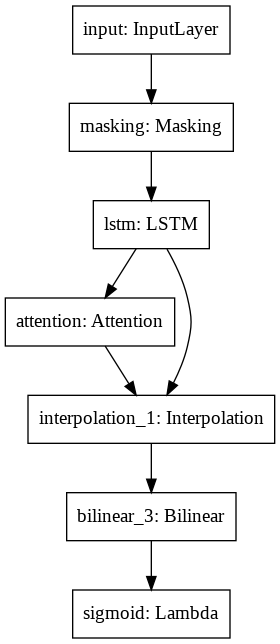

In [ ]:
tf.keras.utils.plot_model(add_model)

In [ ]:
import tensorflow as tf

model_name = add_model.name

best_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_best.hdf5'),
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
last_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_last.hdf5'),
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
 
callbacks = [best_w, last_w]



add_history = add_model.fit(add_train_set,
                    epochs = 50,
                    verbose = 1,
                    validation_data=add_val_set)
                    # callbacks = callbacks)

Epoch 1/50
96/96 [==============================] - 18s 87ms/step - loss: 0.0988 - binary_accuracy: 0.9503 - auc: 0.9810 - precision: 0.7422 - recall: 0.7542 - val_loss: 0.0980 - val_binary_accuracy: 0.9516 - val_auc: 0.9812 - val_precision: 0.7531 - val_recall: 0.7904
Epoch 2/50
96/96 [==============================] - 10s 73ms/step - loss: 0.0984 - binary_accuracy: 0.9518 - auc: 0.9807 - precision: 0.7429 - recall: 0.8031 - val_loss: 0.0972 - val_binary_accuracy: 0.9513 - val_auc: 0.9806 - val_precision: 0.7456 - val_recall: 0.8143
Epoch 3/50
96/96 [==============================] - 10s 73ms/step - loss: 0.0972 - binary_accuracy: 0.9527 - auc: 0.9808 - precision: 0.7371 - recall: 0.8333 - val_loss: 0.0996 - val_binary_accuracy: 0.9517 - val_auc: 0.9802 - val_precision: 0.7435 - val_recall: 0.8459
Epoch 4/50
96/96 [==============================] - 10s 74ms/step - loss: 0.0963 - binary_accuracy: 0.9532 - auc: 0.9808 - precision: 0.7367 - recall: 0.8482 - val_loss: 0.0938 - val_binary_

In [ ]:
filename = os.path.join(HISTORY_PATH, 'NAKTM-LSTM-Multihead3.csv')

history_df = pd.DataFrame(add_history.history)
history_df.to_csv(filename)

Causal = False

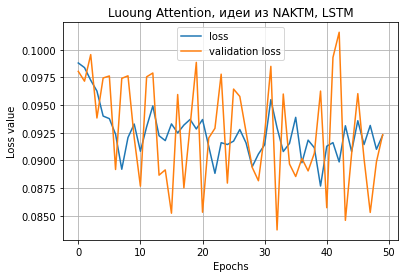

In [ ]:
import matplotlib.pyplot as plt

add_loss = add_history.history['loss']
add_val_loss = add_history.history['val_loss']
epochs = np.arange(len(add_loss))
plt.plot(epochs, add_loss, label = 'loss')
plt.plot(epochs, add_val_loss, label = 'validation loss')
plt.title('Luoung Attention, идеи из NAKTM, LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# import h5py
# with h5py.File(os.path.join(MODELS_PATH, model_name +'_best.hdf5'),'r') as f:
#   best_add_model = tf.keras.models.load_model(f, compile=False, custom_objects = {'Interpolation':Interpolation, 'Bilinear': Bilinear})


# best_add_model.compile(
#         loss = custom_loss,
#         optimizer='adam',
#         metrics=[
#             BinaryAccuracy(),
#             AUC(),
#             Precision(),
#             Recall()
#         ])



add_result = add_model.evaluate(add_test_set, verbose=1)
# best_add_result = best_add_model.evaluate(add_test_set, verbose=1)

# 31/31 [==============================] - 3s 30ms/step - loss: 0.0906 - binary_accuracy: 0.9562 - auc: 0.9818 - precision: 0.7394 - recall: 0.8991

31/31 [==============================] - 3s 30ms/step - loss: 0.0906 - binary_accuracy: 0.9562 - auc: 0.9818 - precision: 0.7394 - recall: 0.8991


Causal = True

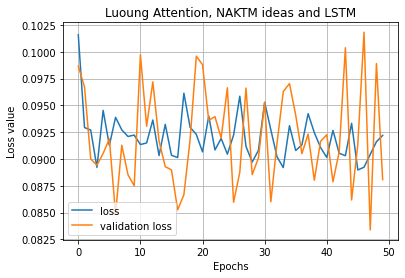

In [ ]:
import matplotlib.pyplot as plt

add_loss = add_history.history['loss']
add_val_loss = add_history.history['val_loss']
epochs = np.arange(len(add_loss))
plt.plot(epochs, add_loss, label = 'loss')
plt.plot(epochs, add_val_loss, label = 'validation loss')
plt.title('Luoung Attention, NAKTM ideas and LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import h5py
with h5py.File(os.path.join(MODELS_PATH, model_name +'_best.hdf5'),'r') as f:
  best_add_model = tf.keras.models.load_model(f, compile=False, custom_objects = {'Interpolation':Interpolation, 'Bilinear': Bilinear})


best_add_model.compile(
        loss = custom_loss,
        optimizer='adam',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
        ])



add_result = add_model.evaluate(add_test_set, verbose=1)
best_add_result = best_add_model.evaluate(add_test_set, verbose=1)

# 31/31 [==============================] - 3s 33ms/step - loss: 0.0901 - binary_accuracy: 0.9576 - auc_16: 0.9819 - precision_16: 0.7311 - recall_16: 0.9097
# 31/31 [==============================] - 5s 32ms/step - loss: 0.0906 - binary_accuracy: 0.9582 - auc_18: 0.9823 - precision_18: 0.7324 - recall_18: 0.9092

31/31 [==============================] - 5s 32ms/step - loss: 0.0906 - binary_accuracy: 0.9582 - auc_18: 0.9823 - precision_18: 0.7324 - recall_18: 0.9092


# MultiHeadAttention, NAKTM ideas and LSTM

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Masking, LSTM, Attention,TimeDistributed, Dense, MultiHeadAttention, Input, AdditiveAttention, Embedding, AveragePooling1D, Softmax, Lambda, Permute
# from keras_self_attention import SeqSelfAttention
from tensorflow.keras.activations import sigmoid

# model = tf.keras.models.Sequential(name = 'SAKT')

inp = Input(shape=(None, add_features_depth), name = 'input')

mask = Masking(mask_value = -1., input_shape = (None, add_features_depth), name = 'masking')(inp)


lstm_output = LSTM(add_features_depth, return_sequences = True, name = 'lstm')(mask)
# attention = AdditiveAttention(causal = True, name = 'attention')([lstm_output, lstm_output]) # query and value respectively
attention = MultiHeadAttention(num_heads=3,key_dim = add_features_depth, name = 'attention')(lstm_output, lstm_output)
# attention = Attention(causal = True, name = 'attention')([lstm_output, lstm_output]) # query and value respectively


interpolation = Interpolation(0.45)([attention, lstm_output])
decoder = Bilinear(exercise_embeddings, states_dim = add_features_depth)(interpolation)


sigm = Lambda(lambda x: tf.sigmoid(x), name = 'sigmoid')(decoder)


add_model = Model(inputs = inp, outputs = sigm, name = 'AD-LSTM')




add_model.compile(
        loss = custom_loss,
        optimizer='adam',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
        ])

add_model.summary()

Model: "AD-LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 50)]   0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, None, 50)     0           input[0][0]                      
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 50)     20200       masking[0][0]                    
__________________________________________________________________________________________________
attention (MultiHeadAttention)  (None, None, 50)     30500       lstm[0][0]                       
                                                                 lstm[0][0]                 

In [ ]:
import tensorflow as tf

# model_name = add_model.name + '(MultiHead)'

model_name = add_model.name + '(MultiHead_3_heads)'

best_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_best.hdf5'),
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
last_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_last.hdf5'),
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
 
callbacks = [best_w, last_w]



add_history = add_model.fit(add_train_set,
                    epochs = 50,
                    verbose = 1,
                    validation_data=add_val_set,
                    callbacks = callbacks)

Epoch 1/50
96/96 [==============================] - 16s 101ms/step - loss: 0.1016 - binary_accuracy: 0.9479 - auc_6: 0.9802 - precision_6: 0.7433 - recall_6: 0.7323 - val_loss: 0.0987 - val_binary_accuracy: 0.9523 - val_auc_6: 0.9803 - val_precision_6: 0.7422 - val_recall_6: 0.8467

Epoch 00001: val_loss improved from inf to 0.09867, saving model to gdrive/MyDrive/Colab Notebooks/FQW/data/models/AD-LSTM(MultiHead_3_heads)_best.hdf5
Epoch 2/50
96/96 [==============================] - 11s 89ms/step - loss: 0.0929 - binary_accuracy: 0.9551 - auc_6: 0.9814 - precision_6: 0.7362 - recall_6: 0.8744 - val_loss: 0.0967 - val_binary_accuracy: 0.9534 - val_auc_6: 0.9801 - val_precision_6: 0.7374 - val_recall_6: 0.8959

Epoch 00002: val_loss improved from 0.09867 to 0.09671, saving model to gdrive/MyDrive/Colab Notebooks/FQW/data/models/AD-LSTM(MultiHead_3_heads)_best.hdf5
Epoch 3/50
96/96 [==============================] - 11s 90ms/step - loss: 0.0927 - binary_accuracy: 0.9564 - auc_6: 0.9818 - 

In [ ]:
filename = os.path.join(HISTORY_PATH, 'NAKTM-LSTM-Multihead3.csv')
# with open(filename, 'wb') as file_pi:
#   pickle.dump(add_history.history, file_pi)

history_df = pd.DataFrame(add_history.history)
history_df.to_csv(filename)

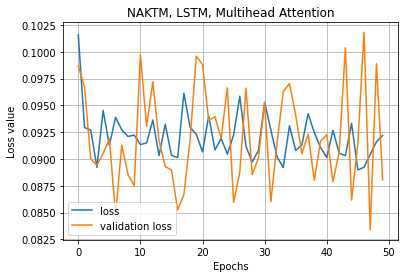

In [ ]:
import matplotlib.pyplot as plt

add_loss = add_history.history['loss']
add_val_loss = add_history.history['val_loss']
epochs = np.arange(len(add_loss))
plt.plot(epochs, add_loss, label = 'loss')
plt.plot(epochs, add_val_loss, label = 'validation loss')
plt.title('NAKTM, LSTM, Multihead Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.grid()
plt.show()

Три головы

In [ ]:
import h5py
with h5py.File(os.path.join(MODELS_PATH, model_name +'_best.hdf5'),'r') as f:
  best_add_model = tf.keras.models.load_model(f, compile=False, custom_objects = {'Interpolation':Interpolation, 'Bilinear': Bilinear})


best_add_model.compile(
        loss = custom_loss,
        optimizer='adam',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
        ])



add_result = add_model.evaluate(add_test_set, verbose=1)
best_add_result = best_add_model.evaluate(add_test_set, verbose=1)

# 31/31 [==============================] - 4s 36ms/step - loss: 0.0930 - binary_accuracy: 0.9555 - auc_6: 0.9814 - precision_6: 0.7332 - recall_6: 0.8990
# 31/31 [==============================] - 5s 38ms/step - loss: 0.0854 - binary_accuracy: 0.9580 - auc_7: 0.9825 - precision_7: 0.7301 - recall_7: 0.8967

31/31 [==============================] - 5s 38ms/step - loss: 0.0854 - binary_accuracy: 0.9580 - auc_7: 0.9825 - precision_7: 0.7301 - recall_7: 0.8967


# Сross признаки

In [ ]:
dataset, length, features_depth, skill_depth = get_dataset(ASSISTMENT_2015_PATH, batch_size = 128,
                                                           features_func=get_cross_features)

In [ ]:
train_set, test_set, val_set = split_dataset(dataset, length, 0.2, 0.2)

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, TimeDistributed, Dense

model = tf.keras.models.Sequential(name = 'LSTM-Cross')

model.add(Masking(mask_value = -1., input_shape = (None, features_depth), name = 'masking'))
model.add(LSTM(features_depth, return_sequences = True, name = 'lstm_1'))
model.add(LSTM(features_depth, return_sequences = True, name = 'lstm_2'))
# model.add(LSTM(features_depth + 30, return_sequences = True, name = 'lstm_3'))
model.add(TimeDistributed(Dense(200, activation = 'relu', name = 'dense_1'), name = 'timedistributed_1'))
model.add(TimeDistributed(Dense(200, activation = 'relu', name = 'dense_2'), name = 'timedistributed_2'))
model.add(TimeDistributed(Dense(200, activation = 'relu', name = 'dense_3'), name = 'timedistributed_3'))
model.add(TimeDistributed(Dense(skill_depth, activation = 'sigmoid', name = 'dense'), name = 'timedistributed'))




# d_model = tf.keras.models.Sequential(name = 'LSTM-Default')

# d_model.add(Masking(mask_value = -1., input_shape = (None, d_features_depth), name = 'masking'))
# d_model.add(LSTM(200, return_sequences = True, name = 'lstm_1'))
# d_model.add(LSTM(200, return_sequences = True, name = 'lstm_2'))
# # d_model.add(LSTM(200, return_sequences = True, name = 'lstm_3'))
# d_model.add(TimeDistributed(Dense(200, activation = 'relu', name = 'dense')))
# d_model.add(TimeDistributed(Dense(200, activation = 'relu', name = 'dense')))
# d_model.add(TimeDistributed(Dense(200, activation = 'relu', name = 'dense')))
# d_model.add(TimeDistributed(Dense(d_skill_depth, activation = 'sigmoid', name = 'dense')))



model.compile(
        loss = custom_loss,
        optimizer='adam',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
        ])

model.summary()

Model: "LSTM-Cross"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 200)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 200)         320800    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 200)         320800    
_________________________________________________________________
timedistributed_1 (TimeDistr (None, None, 200)         40200     
_________________________________________________________________
timedistributed_2 (TimeDistr (None, None, 200)         40200     
_________________________________________________________________
timedistributed_3 (TimeDistr (None, None, 200)         40200     
_________________________________________________________________
timedistributed (TimeDistrib (None, None, 100)         2

In [ ]:
import tensorflow as tf

model_name = model.name

best_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_best.hdf5'),
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
last_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_last.hdf5'),
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
 
callbacks = [best_w, last_w]



history = model.fit(train_set,
                    epochs = 50,
                    verbose = 1,
                    validation_data=val_set,
                    callbacks = callbacks)

Epoch 1/50
96/96 [==============================] - 23s 138ms/step - loss: 0.0855 - binary_accuracy: 0.7214 - auc_40: 0.6129 - precision_40: 0.7349 - recall_40: 0.9693 - val_loss: 0.0835 - val_binary_accuracy: 0.7380 - val_auc_40: 0.6832 - val_precision_40: 0.7421 - val_recall_40: 0.9861

Epoch 00001: val_loss improved from inf to 0.08346, saving model to gdrive/MyDrive/Colab Notebooks/FQW/data/models/LSTM-Cross_best.hdf5
Epoch 2/50
96/96 [==============================] - 14s 117ms/step - loss: 0.0825 - binary_accuracy: 0.7405 - auc_40: 0.6918 - precision_40: 0.7478 - recall_40: 0.9736 - val_loss: 0.0816 - val_binary_accuracy: 0.7465 - val_auc_40: 0.7027 - val_precision_40: 0.7526 - val_recall_40: 0.9772

Epoch 00002: val_loss improved from 0.08346 to 0.08159, saving model to gdrive/MyDrive/Colab Notebooks/FQW/data/models/LSTM-Cross_best.hdf5
Epoch 3/50
96/96 [==============================] - 14s 116ms/step - loss: 0.0822 - binary_accuracy: 0.7458 - auc_40: 0.7047 - precision_40: 0.7

In [ ]:
filename = os.path.join(HISTORY_PATH, 'LSTM-Cross.csv')
# with open(filename, 'wb') as file_pi:
#   pickle.dump(add_history.history, file_pi)

history_df = pd.DataFrame(history.history)
history_df.to_csv(filename)

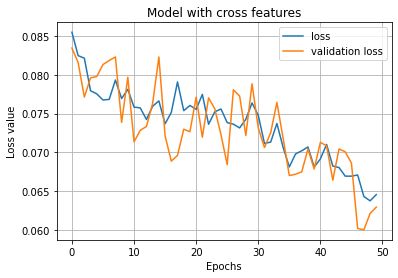

In [ ]:
# Используем cross features
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(len(loss))
plt.plot(epochs, loss, label = 'loss')
plt.plot(epochs, val_loss, label = 'validation loss')
plt.title('Model with cross features')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import h5py
with h5py.File(os.path.join(MODELS_PATH, model_name +'_best.hdf5'),'r') as f:
  best_model = tf.keras.models.load_model(f, compile=False)


best_model.compile(
        loss = custom_loss,
        optimizer='adam',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
        ])




cross_result = model.evaluate(test_set, verbose=1)
best_cross_result = best_model.evaluate(test_set, verbose=1)

# 31/31 [==============================] - 4s 52ms/step - loss: 0.0633 - binary_accuracy: 0.8014 - auc_40: 0.8366 - precision_40: 0.8197 - recall_40: 0.9348
# 31/31 [==============================] - 6s 50ms/step - loss: 0.0648 - binary_accuracy: 0.8000 - auc_41: 0.8326 - precision_41: 0.8214 - recall_41: 0.9298

31/31 [==============================] - 6s 50ms/step - loss: 0.0648 - binary_accuracy: 0.8000 - auc_41: 0.8326 - precision_41: 0.8214 - recall_41: 0.9298


# Обычные признаки

In [ ]:
d_dataset, d_length, d_features_depth, d_skill_depth = get_dataset(ASSISTMENT_2015_PATH, batch_size = 128,
                                                           features_func=get_default_features)

In [ ]:
d_length, d_features_depth, d_skill_depth

(151, 102, 100)

In [ ]:
d_train_set, d_test_set, d_val_set = split_dataset(d_dataset, length, 0.2, 0.2)

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, TimeDistributed, Dense

d_model = tf.keras.models.Sequential(name = 'LSTM-Default')

d_model.add(Masking(mask_value = -1., input_shape = (None, d_features_depth), name = 'masking'))
d_model.add(LSTM(200, return_sequences = True, name = 'lstm_1'))
d_model.add(LSTM(200, return_sequences = True, name = 'lstm_2'))
# d_model.add(LSTM(200, return_sequences = True, name = 'lstm_3'))
d_model.add(TimeDistributed(Dense(200, activation = 'relu', name = 'dense'), name = 'timedistributed_1'))
d_model.add(TimeDistributed(Dense(200, activation = 'relu', name = 'dense'), name = 'timedistributed_2'))
d_model.add(TimeDistributed(Dense(200, activation = 'relu', name = 'dense'), name = 'timedistributed_3'))
d_model.add(TimeDistributed(Dense(d_skill_depth, activation = 'sigmoid', name = 'dense'), name = 'timedistributed'))


# Не забыть поменять custom_loss
d_model.compile(
        loss = custom_loss,
        optimizer='adam',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
        ])

d_model.summary()

Model: "LSTM-Default"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 102)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 200)         242400    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 200)         320800    
_________________________________________________________________
time_distributed_50 (TimeDis (None, None, 200)         40200     
_________________________________________________________________
time_distributed_51 (TimeDis (None, None, 200)         40200     
_________________________________________________________________
time_distributed_52 (TimeDis (None, None, 200)         40200     
_________________________________________________________________
time_distributed_53 (TimeDis (None, None, 100)        

In [ ]:
import tensorflow as tf

model_name = d_model.name

best_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_best.hdf5'),
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
last_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_last.hdf5'),
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
 
callbacks = [best_w, last_w]



d_history = d_model.fit(d_train_set,
                    epochs = 50,
                    verbose = 1,
                    validation_data=d_val_set,
                    callbacks = callbacks)

Epoch 1/50
96/96 [==============================] - 25s 145ms/step - loss: 0.0820 - binary_accuracy: 0.7210 - auc_56: 0.6191 - precision_56: 0.7358 - recall_56: 0.9653 - val_loss: 0.0784 - val_binary_accuracy: 0.7400 - val_auc_56: 0.6810 - val_precision_56: 0.7436 - val_recall_56: 0.9884

Epoch 00001: val_loss improved from inf to 0.07845, saving model to gdrive/MyDrive/Colab Notebooks/FQW/data/models/LSTM-Default_best.hdf5
Epoch 2/50
96/96 [==============================] - 15s 114ms/step - loss: 0.0803 - binary_accuracy: 0.7391 - auc_56: 0.6899 - precision_56: 0.7459 - recall_56: 0.9752 - val_loss: 0.0796 - val_binary_accuracy: 0.7441 - val_auc_56: 0.6921 - val_precision_56: 0.7592 - val_recall_56: 0.9549

Epoch 00002: val_loss did not improve from 0.07845
Epoch 3/50
96/96 [==============================] - 14s 115ms/step - loss: 0.0801 - binary_accuracy: 0.7435 - auc_56: 0.6995 - precision_56: 0.7555 - recall_56: 0.9601 - val_loss: 0.0818 - val_binary_accuracy: 0.7502 - val_auc_56: 

In [ ]:
filename = os.path.join(HISTORY_PATH, 'LSTM-Default.csv')
# with open(filename, 'wb') as file_pi:
#   pickle.dump(add_history.history, file_pi)

history_df = pd.DataFrame(history.history)
history_df.to_csv(filename)

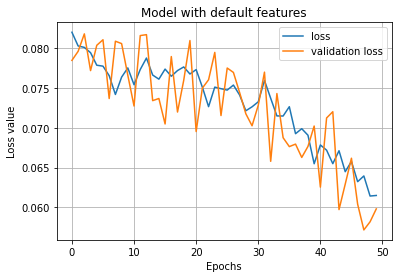

In [ ]:
# Используем cross features
import matplotlib.pyplot as plt

default_loss = d_history.history['loss']
default_val_loss = d_history.history['val_loss']
epochs = np.arange(len(default_loss))
plt.plot(epochs, default_loss, label = 'loss')
plt.plot(epochs, default_val_loss, label = 'validation loss')
plt.title('Model with default features')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import h5py
with h5py.File(os.path.join(MODELS_PATH, model_name +'_best.hdf5'),'r') as f:
  d_best_model = tf.keras.models.load_model(f, compile=False)


d_best_model.compile(
        loss = custom_loss,
        optimizer='adam',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
        ])




default_result = d_model.evaluate(d_test_set, verbose=1)
d_best_result = d_best_model.evaluate(d_test_set, verbose=1)

# 31/31 [==============================] - 4s 47ms/step - loss: 0.0603 - binary_accuracy: 0.8132 - auc_23: 0.8537 - precision_23: 0.8295 - recall_23: 0.9371
# 31/31 [==============================] - 7s 45ms/step - loss: 0.0606 - binary_accuracy: 0.8098 - auc_25: 0.8507 - precision_25: 0.8278 - recall_25: 0.9347

31/31 [==============================] - 6s 46ms/step - loss: 0.0638 - binary_accuracy: 0.8118 - auc_57: 0.8500 - precision_57: 0.8309 - recall_57: 0.9331


# Embedding признаки

In [ ]:
from collections import OrderedDict

word2vec, df, skill_with_answer = get_word2vec(ASSISTMENT_2015_PATH, embedding_size = 100) # TODO: Try features from EERN

In [ ]:
e_dataset, e_features_depth, e_skill_depth, e_users = get_embedding_features(df, word2vec)
e_dataset, e_length = get_embedding_dataset(e_dataset, e_features_depth, e_skill_depth, e_users, batch_size = 128)

In [ ]:
# e_dataset, e_length, e_features_depth, e_skill_depth = get_dataset(ASSISTMENT_2015_PATH, batch_size = 128,
#                                                            features_func=get_embedding_features)

In [ ]:
e_length, e_features_depth, e_skill_depth

(151, 100, 100)

In [ ]:
e_train_set, e_test_set, e_val_set = split_dataset(e_dataset, e_length, 0.2, 0.2)

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, TimeDistributed, Dense

e_model = tf.keras.models.Sequential(name = 'LSTM-Default')

e_model.add(Masking(mask_value = -1., input_shape = (None, e_features_depth), name = 'masking'))
e_model.add(LSTM(200, return_sequences = True, name = 'lstm_1'))
e_model.add(LSTM(200, return_sequences = True, name = 'lstm_2'))
e_model.add(TimeDistributed(Dense(200, activation = 'relu', name = 'dense_1')))
e_model.add(TimeDistributed(Dense(200, activation = 'relu', name = 'dense_2')))
e_model.add(TimeDistributed(Dense(200, activation = 'relu', name = 'dense_3')))
e_model.add(TimeDistributed(Dense(e_skill_depth, activation = 'sigmoid', name = 'dense')))


# Не забыть поменять custom_loss
e_model.compile(
        loss = custom_loss,
        optimizer='adam',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
        ])

e_model.summary()

Model: "LSTM-Default"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 200)         240800    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 200)         320800    
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 200)         40200     
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 200)         40200     
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 200)         40200     
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 100)        

In [ ]:
import tensorflow as tf

model_name = e_model.name

best_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_best.hdf5'),
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
last_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_last.hdf5'),
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
 
callbacks = [best_w, last_w]



e_history = e_model.fit(e_train_set,
                    epochs = 50,
                    verbose = 1,
                    validation_data=e_val_set)

Epoch 1/50
96/96 [==============================] - 22s 136ms/step - loss: 0.0840 - binary_accuracy: 0.7205 - auc_1: 0.5861 - precision_1: 0.7344 - recall_1: 0.9680 - val_loss: 0.0813 - val_binary_accuracy: 0.7380 - val_auc_1: 0.6358 - val_precision_1: 0.7384 - val_recall_1: 0.9986
Epoch 2/50
96/96 [==============================] - 15s 123ms/step - loss: 0.0838 - binary_accuracy: 0.7304 - auc_1: 0.6330 - precision_1: 0.7310 - recall_1: 0.9982 - val_loss: 0.0834 - val_binary_accuracy: 0.7351 - val_auc_1: 0.6357 - val_precision_1: 0.7354 - val_recall_1: 0.9992
Epoch 3/50
96/96 [==============================] - 13s 110ms/step - loss: 0.0843 - binary_accuracy: 0.7311 - auc_1: 0.6348 - precision_1: 0.7322 - recall_1: 0.9967 - val_loss: 0.0861 - val_binary_accuracy: 0.7381 - val_auc_1: 0.6402 - val_precision_1: 0.7408 - val_recall_1: 0.9922
Epoch 4/50
96/96 [==============================] - 13s 107ms/step - loss: 0.0843 - binary_accuracy: 0.7313 - auc_1: 0.6386 - precision_1: 0.7325 - rec

In [ ]:
filename = os.path.join(HISTORY_PATH, 'LSTM-Embedding100.csv')
# with open(filename, 'wb') as file_pi:
#   pickle.dump(add_history.history, file_pi)

history_df = pd.DataFrame(e_history.history)
history_df.to_csv(filename)

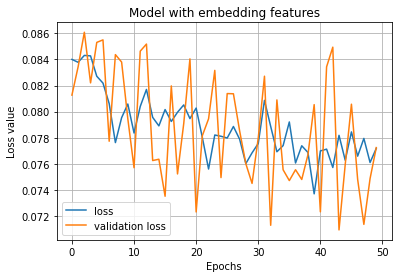

In [ ]:
# Используем cross features
import matplotlib.pyplot as plt

e_loss = e_history.history['loss']
e_val_loss = e_history.history['val_loss']
epochs = np.arange(len(e_loss))
plt.plot(epochs, e_loss, label = 'loss')
plt.plot(epochs, e_val_loss, label = 'validation loss')
plt.title('Model with embedding features')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import h5py
with h5py.File(os.path.join(MODELS_PATH, model_name +'_best.hdf5'),'r') as f:
  e_best_model = tf.keras.models.load_model(f, compile=False)


e_best_model.compile(
        loss = custom_loss,
        optimizer='adam',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
        ])



# 100 emb_size
e_result = e_model.evaluate(e_test_set, verbose=1)
e_best_result = e_best_model.evaluate(e_test_set, verbose=1)

# 31/31 [==============================] - 4s 45ms/step - loss: 0.0758 - binary_accuracy: 0.7557 - auc_52: 0.7303 - precision_52: 0.7726 - recall_52: 0.9471
# 31/31 [==============================] - 6s 46ms/step - loss: 0.1021 - binary_accuracy: 0.6218 - auc_53: 0.5887 - precision_53: 0.7693 - recall_53: 0.6915

31/31 [==============================] - 6s 44ms/step - loss: 0.1128 - binary_accuracy: 0.7126 - auc_2: 0.5708 - precision_2: 0.7374 - recall_2: 0.9445


In [ ]:
import h5py
with h5py.File(os.path.join(MODELS_PATH, model_name +'_best.hdf5'),'r') as f:
  e_best_model = tf.keras.models.load_model(f, compile=False)


e_best_model.compile(
        loss = custom_loss,
        optimizer='adam',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
        ])



# 50 emb_size
e_result = e_model.evaluate(e_test_set, verbose=1)
e_best_result = e_best_model.evaluate(e_test_set, verbose=1)


# 31/31 [==============================] - 4s 41ms/step - loss: 0.0756 - binary_accuracy: 0.7571 - auc_49: 0.7318 - precision_49: 0.7719 - recall_49: 0.9514
# 31/31 [==============================] - 6s 42ms/step - loss: 0.0950 - binary_accuracy: 0.6926 - auc_50: 0.5658 - precision_50: 0.7467 - recall_50: 0.8789

31/31 [==============================] - 7s 45ms/step - loss: 0.0873 - binary_accuracy: 0.6908 - auc_51: 0.5600 - precision_51: 0.7451 - recall_51: 0.8790


In [ ]:
import h5py
with h5py.File(os.path.join(MODELS_PATH, model_name +'_best.hdf5'),'r') as f:
  e_best_model = tf.keras.models.load_model(f, compile=False)


e_best_model.compile(
        loss = custom_loss,
        optimizer='adam',
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall()
        ])



# 10 emb_size
e_result = e_model.evaluate(e_test_set, verbose=1)
e_best_result = e_best_model.evaluate(e_test_set, verbose=1)


# 31/31 [==============================] - 4s 40ms/step - loss: 0.0733 - binary_accuracy: 0.7617 - auc_47: 0.7590 - precision_47: 0.7813 - recall_47: 0.9359
# 31/31 [==============================] - 6s 40ms/step - loss: 0.0947 - binary_accuracy: 0.6403 - auc_48: 0.5906 - precision_48: 0.7655 - recall_48: 0.7353

31/31 [==============================] - 6s 40ms/step - loss: 0.0947 - binary_accuracy: 0.6403 - auc_48: 0.5906 - precision_48: 0.7655 - recall_48: 0.7353


In [ ]:
# # deafult features 0
# d_result = d_model.evaluate(d_test_set, verbose=1)

In [ ]:
# # cross features
# cross_result = model.evaluate(test_set, verbose=1)

31/31 [==============================] - 5s 163ms/step - loss: 0.0740 - binary_accuracy: 0.7649 - auc_18: 0.7622 - precision_18: 0.7808 - recall_18: 0.9442


In [ ]:
# # deafult features 1
# d_result = d_model.evaluate(d_test_set, verbose=1)

31/31 [==============================] - 5s 152ms/step - loss: 0.0714 - binary_accuracy: 0.7607 - auc_16: 0.7563 - precision_16: 0.7813 - recall_16: 0.9345


In [ ]:
# e_result = e_model.evaluate(e_test_set, verbose=1)

31/31 [==============================] - 4s 122ms/step - loss: 0.0839 - binary_accuracy: 0.7386 - auc_19: 0.6717 - precision_19: 0.7419 - recall_19: 0.9874


# EERN признаки

In [ ]:
from collections import OrderedDict

word2vec, df, skill_with_answer = get_word2vec(ASSISTMENT_2015_PATH, embedding_size = 10, skill_with_answer = False) # TODO: Try features from EERN

In [ ]:
eern_dataset, eern_features_depth, eern_skill_depth, eern_users = get_eern_features(df, word2vec)
eern_dataset, eern_length = get_embedding_dataset(eern_dataset, eern_features_depth, eern_skill_depth, eern_users, batch_size = 128)

In [ ]:
eern_length, eern_features_depth, eern_skill_depth

(151, 20, 100)

In [ ]:
eern_train_set, eern_test_set, eern_val_set = split_dataset(eern_dataset, eern_length, 0.2, 0.2)

In [ ]:
sum = 0
for batch in eern_test_set:
  sum += batch[0].shape[0]

In [ ]:
sum

3968

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, TimeDistributed, Dense

eern_model = tf.keras.models.Sequential(name = 'LSTM-EERNFeatures')

eern_model.add(Masking(mask_value = -1., input_shape = (None, eern_features_depth), name = 'masking'))
eern_model.add(LSTM(200, return_sequences = True, name = 'lstm_1'))
eern_model.add(LSTM(200, return_sequences = True, name = 'lstm_2'))
eern_model.add(TimeDistributed(Dense(200, activation = 'relu', name = 'dense_1')))
eern_model.add(TimeDistributed(Dense(200, activation = 'relu', name = 'dense_2')))
eern_model.add(TimeDistributed(Dense(200, activation = 'relu', name = 'dense_3')))
eern_model.add(TimeDistributed(Dense(eern_skill_depth, activation = 'sigmoid', name = 'dense')))


eern_model.compile(
       loss = custom_loss,
       optimizer='adam',
       metrics=[
           BinaryAccuracy(),
           AUC(),
           Precision(),
           Recall()
       ])

eern_model.summary()

Model: "LSTM-EERNFeatures"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 20)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 200)         176800    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 200)         320800    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 200)         40200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 200)         40200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 200)         40200     
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 100)   

In [ ]:
import tensorflow as tf

model_name = eern_model.name
best_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_best.hdf5'),
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
last_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_last.hdf5'),
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
 
callbacks = [best_w, last_w]

eern_history = eern_model.fit(eern_train_set,
                    epochs = 50,
                    verbose = 1,
                    validation_data=eern_val_set)

Epoch 1/50
96/96 [==============================] - 27s 126ms/step - loss: 0.0872 - binary_accuracy: 0.7256 - auc: 0.5855 - precision: 0.7353 - recall: 0.9775 - val_loss: 0.0836 - val_binary_accuracy: 0.7361 - val_auc: 0.6322 - val_precision: 0.7361 - val_recall: 1.0000
Epoch 2/50
96/96 [==============================] - 13s 100ms/step - loss: 0.0854 - binary_accuracy: 0.7326 - auc: 0.6329 - precision: 0.7334 - recall: 0.9977 - val_loss: 0.0887 - val_binary_accuracy: 0.7296 - val_auc: 0.6446 - val_precision: 0.7296 - val_recall: 1.0000
Epoch 3/50
96/96 [==============================] - 13s 100ms/step - loss: 0.0847 - binary_accuracy: 0.7334 - auc: 0.6354 - precision: 0.7347 - recall: 0.9961 - val_loss: 0.0868 - val_binary_accuracy: 0.7329 - val_auc: 0.6378 - val_precision: 0.7332 - val_recall: 0.9993
Epoch 4/50
96/96 [==============================] - 13s 103ms/step - loss: 0.0820 - binary_accuracy: 0.7334 - auc: 0.6373 - precision: 0.7342 - recall: 0.9976 - val_loss: 0.0905 - val_bin

In [ ]:
filename = os.path.join(HISTORY_PATH, 'LSTM-EERN.csv')

history_df = pd.DataFrame(eern_history.history)
history_df.to_csv(filename)

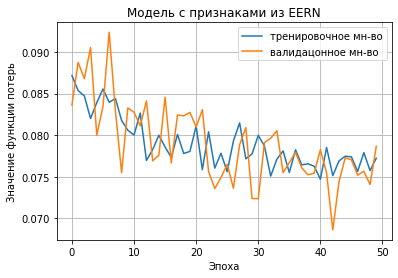

In [ ]:
import matplotlib.pyplot as plt

eern_loss = eern_history.history['loss']
eern_val_loss = eern_history.history['val_loss']
epochs = np.arange(len(eern_loss))
plt.plot(epochs, eern_loss, label = 'тренировочное мн-во')
plt.plot(epochs, eern_val_loss, label = 'валидацонное мн-во')
plt.title('Модель с признаками из EERN')
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.legend()
plt.grid()
plt.show()

In [ ]:
eern_result = eern_model.evaluate(eern_test_set, verbose=1)

31/31 [==============================] - 4s 41ms/step - loss: 0.0749 - binary_accuracy: 0.7564 - auc: 0.7419 - precision: 0.7756 - recall: 0.9379


In [ ]:
# import h5py
# with h5py.File(model_name +'_best.hdf5','r') as f:
#     eern_best_model = tf.keras.models.load_model(f, compile=False)


# eeern_best_model.compile(
#         loss = custom_loss,
#         optimizer='adam',
#         metrics=[
#             BinaryAccuracy(),
#             AUC(),
#             Precision(),
#             Recall()
#         ])



# 10 emb_size
eeern_result = eern_model.evaluate(eern_test_set, verbose=1)
# eeern_best_result = e_best_model.evaluate(e_test_set, verbose=1)


# 31/31 [==============================] - 4s 38ms/step - loss: 0.0668 - binary_accuracy: 0.7730 - auc_3: 0.7765 - precision_3: 0.7939 - recall_3: 0.9331

# Transformer Encoder

In [ ]:
from collections import OrderedDict

word2vec, df, skill_with_answer = get_word2vec(ASSISTMENT_2015_PATH, embedding_size = 100)

In [ ]:
mh_dataset, mh_features_depth, mh_skill_depth, mh_users = get_embedding_features(df, word2vec)
mh_dataset, mh_length = get_embedding_dataset(mh_dataset, mh_features_depth, mh_skill_depth, mh_users, batch_size = 128)

In [ ]:
mh_length, mh_features_depth, mh_skill_depth

(151, 100, 100)

In [ ]:
mh_train_set, mh_test_set, mh_val_set = split_dataset(mh_dataset, mh_length, 0.2, 0.2)

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim, trainable = False)

    def call(self, x):
        maxlen = tf.shape(x)[1]
        # maxlen = 493
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        # x = self.token_emb(x)
        return x + positions

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        # attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        # ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [ ]:
embed_dim = mh_features_depth 
# num_heads = 2  
num_heads = 4  
ff_dim = 512  
# maxlen = 101
# maxlen = 493 + 1
maxlen = 800
vocab_size = mh_features_depth





inputs = tf.keras.layers.Input(shape=(None,mh_features_depth,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, mh_features_depth)
x = tf.keras.layers.Masking(mask_value = -1., input_shape = (None, mh_features_depth), name = 'masking')(inputs)
x = embedding_layer(x)
transformer_block_1 = TransformerBlock(mh_features_depth, num_heads, ff_dim)
transformer_block_2 = TransformerBlock(mh_features_depth, num_heads, ff_dim)
x = transformer_block_1(x)
x = transformer_block_2(x)
outputs = tf.keras.layers.Dense(mh_skill_depth, activation="sigmoid")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name = 'Transformer-Encoder')


model.compile(
       loss = custom_loss,
       optimizer='adam',
       metrics=[
           BinaryAccuracy(),
           AUC(),
           Precision(),
           Recall()
       ])

model.summary()

Model: "Transformer-Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, 100)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 100)         0         
_________________________________________________________________
token_and_position_embedding (None, None, 100)         80000     
_________________________________________________________________
transformer_block_4 (Transfo (None, None, 100)         264712    
_________________________________________________________________
transformer_block_5 (Transfo (None, None, 100)         264712    
_________________________________________________________________
dense_14 (Dense)             (None, None, 100)         10100     
Total params: 619,524
Trainable params: 539,524
Non-trainable params: 80,000
____________________________________

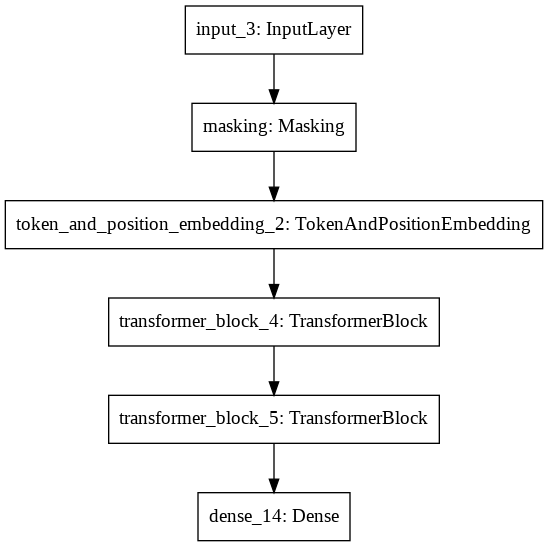

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
import tensorflow as tf

model_name = model.name
best_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_best.hdf5'),
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
last_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_PATH, model_name + '_last.hdf5'),
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto'
                                # save_freq = 1_000
                                )
 
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
 
callbacks = [best_w, last_w]



history = model.fit(mh_train_set,
                    epochs = 50,
                    verbose = 1,
                    validation_data=mh_val_set)
                    # callbacks = callbacks)

Epoch 1/50
96/96 [==============================] - 24s 195ms/step - loss: 0.0870 - binary_accuracy: 0.9607 - auc_2: 0.9838 - precision_2: 0.7348 - recall_2: 0.9725 - val_loss: 0.0892 - val_binary_accuracy: 0.9603 - val_auc_2: 0.9840 - val_precision_2: 0.7315 - val_recall_2: 0.9868
Epoch 2/50
96/96 [==============================] - 21s 188ms/step - loss: 0.0850 - binary_accuracy: 0.9619 - auc_2: 0.9844 - precision_2: 0.7370 - recall_2: 0.9866 - val_loss: 0.0872 - val_binary_accuracy: 0.9612 - val_auc_2: 0.9839 - val_precision_2: 0.7330 - val_recall_2: 1.0000
Epoch 3/50
96/96 [==============================] - 22s 201ms/step - loss: 0.0821 - binary_accuracy: 0.9635 - auc_2: 0.9851 - precision_2: 0.7360 - recall_2: 0.9908 - val_loss: 0.0906 - val_binary_accuracy: 0.9582 - val_auc_2: 0.9826 - val_precision_2: 0.7381 - val_recall_2: 0.9906
Epoch 4/50
96/96 [==============================] - 21s 193ms/step - loss: 0.0842 - binary_accuracy: 0.9626 - auc_2: 0.9846 - precision_2: 0.7346 - rec

In [ ]:
filename = os.path.join(HISTORY_PATH, 'Transformer-Encoder(2 layers, without dropout).csv')

history_df = pd.DataFrame(history.history)
history_df.to_csv(filename)

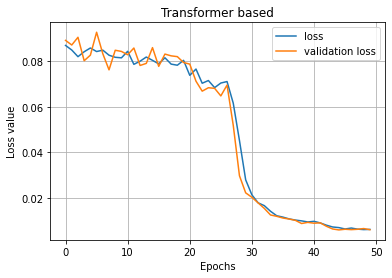

In [ ]:
import matplotlib.pyplot as plt

mh_loss = history.history['loss']
mh_val_loss = history.history['val_loss']
epochs = np.arange(len(mh_loss))
plt.plot(epochs, mh_loss, label = 'loss')
plt.plot(epochs, mh_val_loss, label = 'validation loss')
plt.title('Transformer based')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import h5py

# file = h5py.File(os.path.join(MODELS_PATH, model_name +'_best.hdf5'),'r')
# best_model = tf.keras.models.load_model(file, compile=False)

# best_model.compile(
#         loss = custom_loss,
#         optimizer='adam',
#         metrics=[
#             BinaryAccuracy(),
#             AUC(),
#             Precision(),
#             Recall()
#         ])



result = model.evaluate(mh_test_set, verbose=1)
# best_result = best_mh_model.evaluate(mh_test_set, verbose=1)



# Без dropout, without positional encoding
# 31/31 [==============================] - 4s 53ms/step - loss: 0.1266 - binary_accuracy: 0.9536 - auc_6: 0.9800 - precision_6: 0.8195 - recall_6: 0.7104
# С dropout, without positional encoding
# 31/31 [==============================] - 4s 49ms/step - loss: 0.1302 - binary_accuracy: 0.9516 - auc_7: 0.9789 - precision_7: 0.8140 - recall_7: 0.7288

# C posistional encoding, without dropout
# 31/31 [==============================] - 5s 78ms/step - loss: 0.0057 - binary_accuracy: 0.9973 - auc_2: 0.9999 - precision_2: 0.9820 - recall_2: 0.9914


# С dropout, with positional encoding
# [0.002703981241211295,
#  0.9987738728523254,
#  0.9999852776527405,
#  0.9918460249900818,
#  0.9963680505752563]

31/31 [==============================] - 5s 78ms/step - loss: 0.0057 - binary_accuracy: 0.9973 - auc_2: 0.9999 - precision_2: 0.9820 - recall_2: 0.9914
